In [1]:
import logging

import probtorch
import torch

import combinators
import importance
import mcmc
import ssm
import utils

In [2]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [3]:
generative = combinators.BroadcastingTrace(1)

In [4]:
mu = torch.zeros(1)
sigma = torch.ones(1) / 2
delta = torch.ones(1)
zs = torch.ones(50+1) * -1
zs[0] = 0

In [5]:
ssm_step = combinators.Model(ssm.ssm_step)

In [6]:
for t in range(zs.shape[0] - 1):
    zs[t+1], mu, sigma, delta = ssm_step((zs[t], mu, sigma, delta), t, trace=generative)

In [7]:
data = generative.unwrap(lambda k, rv: 'X_' in k)

In [8]:
num_particles = 100

In [9]:
ssm_params = {
    'mu': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    },
    'sigma': {
        'loc': torch.tensor(1.),
        'scale': torch.tensor(0.25),
    },
    'delta': {
        'loc': torch.tensor(0.),
        'scale': torch.tensor(0.25),
    }
}

In [10]:
init_ssm_generative = combinators.Model(ssm.init_ssm, hyper=ssm_params)
ssm_step_generative = combinators.Model(ssm.ssm_step)
smc_ssm = importance.ImportanceResampler.smc(ssm_step_generative, 50, initializer=init_ssm_generative)

In [11]:
init_ssm_proposal = combinators.Model(ssm.init_ssm, trainable=ssm_params)
ssm_step_proposal = combinators.Model(ssm.ssm_step)
ssm_proposal = combinators.Reduce.sequence(ssm_step_proposal, 50, initializer=init_ssm_proposal)

In [12]:
ssm_importance = importance.ImportanceSampler(model=smc_ssm, proposal=ssm_proposal)

In [13]:
inference, init_ssm_params, elbos = importance.variational_importance(
    num_particles, ssm_importance, 2000,
    data, use_cuda=False, lr=1e-1, patience=500
)

10/26/2018 11:42:15 ELBO=-1.90027710e+02 at epoch 1
10/26/2018 11:42:15 ELBO=-5.12157593e+02 at epoch 2
10/26/2018 11:42:15 ELBO=-2.84204407e+02 at epoch 3
10/26/2018 11:42:16 ELBO=-4.69293701e+02 at epoch 4
10/26/2018 11:42:16 ELBO=-3.53403717e+02 at epoch 5
10/26/2018 11:42:16 ELBO=-1.34739514e+03 at epoch 6
10/26/2018 11:42:16 ELBO=-4.17844330e+02 at epoch 7
10/26/2018 11:42:17 ELBO=-1.90006210e+02 at epoch 8
10/26/2018 11:42:17 ELBO=-2.45093796e+02 at epoch 9
10/26/2018 11:42:17 ELBO=-3.78142822e+02 at epoch 10
10/26/2018 11:42:17 ELBO=-3.26950195e+02 at epoch 11
10/26/2018 11:42:18 ELBO=-6.98943359e+02 at epoch 12
10/26/2018 11:42:18 ELBO=-6.78860291e+02 at epoch 13
10/26/2018 11:42:18 ELBO=-1.18914441e+03 at epoch 14
10/26/2018 11:42:18 ELBO=-2.29288574e+02 at epoch 15
10/26/2018 11:42:19 ELBO=-2.64017883e+02 at epoch 16
10/26/2018 11:42:19 ELBO=-2.92814819e+02 at epoch 17
10/26/2018 11:42:19 ELBO=-3.75363129e+02 at epoch 18
10/26/2018 11:42:19 ELBO=-2.67713135e+02 at epoch 19
10

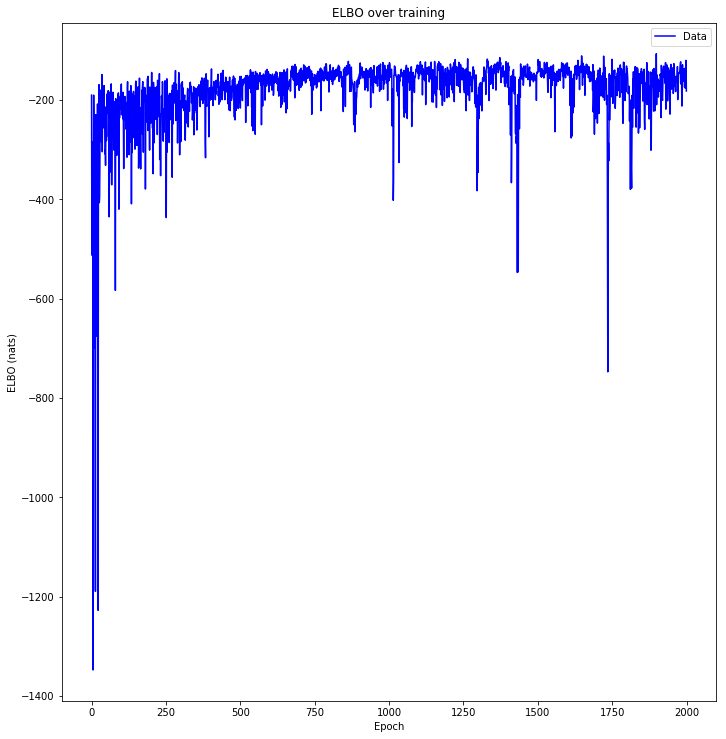

In [14]:
utils.plot_evidence_bounds(elbos)

In [15]:
for t in range(1, zs.shape[0]):
    key = 'Z_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 0.011254
SMC MSE at time 2: 0.112053
SMC MSE at time 3: 0.024756
SMC MSE at time 4: 4.675852
SMC MSE at time 5: 3.761342
SMC MSE at time 6: 0.015466
SMC MSE at time 7: 0.899174
SMC MSE at time 8: 2.270351
SMC MSE at time 9: 0.867576
SMC MSE at time 10: 0.102132
SMC MSE at time 11: 0.569876
SMC MSE at time 12: 0.616603
SMC MSE at time 13: 0.827877
SMC MSE at time 14: 2.017787
SMC MSE at time 15: 1.683088
SMC MSE at time 16: 36.375957
SMC MSE at time 17: 49.307083
SMC MSE at time 18: 45.580570
SMC MSE at time 19: 50.626884
SMC MSE at time 20: 60.426476
SMC MSE at time 21: 48.623463
SMC MSE at time 22: 67.926559
SMC MSE at time 23: 66.993011
SMC MSE at time 24: 66.672859
SMC MSE at time 25: 95.083786
SMC MSE at time 26: 96.590889
SMC MSE at time 27: 103.299553
SMC MSE at time 28: 77.834183
SMC MSE at time 29: 90.123573
SMC MSE at time 30: 95.604156
SMC MSE at time 31: 80.499557
SMC MSE at time 32: 68.009590
SMC MSE at time 33: 74.826286
SMC MSE at time 34: 54.472111
SMC

In [16]:
particle_mh = mcmc.IndependentMH(smc_ssm, ssm_proposal, 1000)

In [17]:
samples, elbos = particle_mh(trace=importance.ResamplerTrace(num_particles, data=data))
inference = particle_mh.trace

In [18]:
inference

Trace{'mu': Normal([torch.FloatTensor of size 100]), 'sigma': Normal([torch.FloatTensor of size 100]), 'delta': Normal([torch.FloatTensor of size 100]), 'Z_0': Normal([torch.FloatTensor of size 100]), 'Z_1': Normal([torch.FloatTensor of size 100]), 'X_1': Normal([torch.FloatTensor of size 100]), 'Z_2': Normal([torch.FloatTensor of size 100]), 'X_2': Normal([torch.FloatTensor of size 100]), 'Z_3': Normal([torch.FloatTensor of size 100]), 'X_3': Normal([torch.FloatTensor of size 100]), 'Z_4': Normal([torch.FloatTensor of size 100]), 'X_4': Normal([torch.FloatTensor of size 100]), 'Z_5': Normal([torch.FloatTensor of size 100]), 'X_5': Normal([torch.FloatTensor of size 100]), 'Z_6': Normal([torch.FloatTensor of size 100]), 'X_6': Normal([torch.FloatTensor of size 100]), 'Z_7': Normal([torch.FloatTensor of size 100]), 'X_7': Normal([torch.FloatTensor of size 100]), 'Z_8': Normal([torch.FloatTensor of size 100]), 'X_8': Normal([torch.FloatTensor of size 100]), 'Z_9': Normal([torch.FloatTenso

In [19]:
generative

Trace{'Z_1': Normal([torch.FloatTensor of size 1]), 'X_1': Normal([torch.FloatTensor of size 1]), 'Z_2': Normal([torch.FloatTensor of size 1]), 'X_2': Normal([torch.FloatTensor of size 1]), 'Z_3': Normal([torch.FloatTensor of size 1]), 'X_3': Normal([torch.FloatTensor of size 1]), 'Z_4': Normal([torch.FloatTensor of size 1]), 'X_4': Normal([torch.FloatTensor of size 1]), 'Z_5': Normal([torch.FloatTensor of size 1]), 'X_5': Normal([torch.FloatTensor of size 1]), 'Z_6': Normal([torch.FloatTensor of size 1]), 'X_6': Normal([torch.FloatTensor of size 1]), 'Z_7': Normal([torch.FloatTensor of size 1]), 'X_7': Normal([torch.FloatTensor of size 1]), 'Z_8': Normal([torch.FloatTensor of size 1]), 'X_8': Normal([torch.FloatTensor of size 1]), 'Z_9': Normal([torch.FloatTensor of size 1]), 'X_9': Normal([torch.FloatTensor of size 1]), 'Z_10': Normal([torch.FloatTensor of size 1]), 'X_10': Normal([torch.FloatTensor of size 1]), 'Z_11': Normal([torch.FloatTensor of size 1]), 'X_11': Normal([torch.Flo

In [20]:
for t in range(1, zs.shape[0]):
    key = 'Z_%d' % t
    accuracy = ((inference[key].value - utils.optional_to(generative[key], inference[key].value))**2).mean()
    print('SMC MSE at time %d: %f' % (t, accuracy))

SMC MSE at time 1: 2.611128
SMC MSE at time 2: 2.246291
SMC MSE at time 3: 0.663222
SMC MSE at time 4: 0.555943
SMC MSE at time 5: 0.394518
SMC MSE at time 6: 0.254794
SMC MSE at time 7: 0.002036
SMC MSE at time 8: 2.275218
SMC MSE at time 9: 0.396662
SMC MSE at time 10: 0.371768
SMC MSE at time 11: 0.632926
SMC MSE at time 12: 0.226446
SMC MSE at time 13: 2.431737
SMC MSE at time 14: 0.015473
SMC MSE at time 15: 1.559713
SMC MSE at time 16: 0.036700
SMC MSE at time 17: 0.054820
SMC MSE at time 18: 0.270727
SMC MSE at time 19: 0.269627
SMC MSE at time 20: 0.756860
SMC MSE at time 21: 0.432428
SMC MSE at time 22: 0.445737
SMC MSE at time 23: 0.976107
SMC MSE at time 24: 0.272098
SMC MSE at time 25: 1.233261
SMC MSE at time 26: 1.785825
SMC MSE at time 27: 4.884912
SMC MSE at time 28: 1.393069
SMC MSE at time 29: 4.133101
SMC MSE at time 30: 107.716789
SMC MSE at time 31: 93.341667
SMC MSE at time 32: 82.559525
SMC MSE at time 33: 87.071350
SMC MSE at time 34: 66.035591
SMC MSE at time 3

In [21]:
elbos

tensor([-226.5100, -145.9019, -145.9019, -145.9019, -145.9019, -145.9019,
        -145.9019, -140.2672, -136.7693, -136.7693, -136.7693, -136.7693,
        -136.7693, -136.7693, -136.7693, -136.7693, -136.7693, -136.7693,
        -128.0250, -128.0250, -128.0250, -128.0250, -128.0250, -128.0250,
        -128.0250, -128.0250, -128.0250, -128.0250, -128.0250, -128.0250,
        -128.0250, -128.0250, -128.0250, -128.0250, -128.0250, -128.0250,
        -128.0250, -128.0250, -128.0250, -128.0250, -128.0250, -128.0250,
        -128.0250, -128.0250, -128.0250, -128.0250, -128.0250, -128.0250,
        -128.0250, -128.0250, -128.0250, -128.0250, -128.0250, -123.5509,
        -123.5509, -123.5509, -123.5509, -123.5509, -123.5509, -123.5509,
        -123.5509, -123.5509, -123.5509, -123.5509, -123.5509, -123.5509,
        -123.5509, -123.5509, -123.5509, -123.5509, -123.5509, -123.5509,
        -123.5509, -123.5509, -123.5509, -123.5509, -123.5509, -123.5509,
        -123.5509, -123.5509, -123.550